In [113]:
import chemfold as cf
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import matplotlib.pyplot as plt
from itertools import combinations

# Check distance distribution to closest drug 

In [114]:
def compute_tanimoto_distance_from_df(df):
    """
    Computes Tanimoto distance between all pairs of SMILES strings in a DataFrame.

    Parameters:
    - df: DataFrame with SMILES strings in a column.

    Returns:
    - distances_df: DataFrame containing Tanimoto distances between all pairs of SMILES strings.
    """
    # Convert SMILES strings to RDKit Mol objects
    mols = [Chem.MolFromSmiles(smiles) for smiles in df['SMILES']]

    # Calculate fingerprints for each molecule
    fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in mols]

    # Compute Tanimoto distance between all pairs of fingerprints
    distances = []

    similarity_df = pd.DataFrame(index=df.index, columns=df.index)
    for i, j in combinations(range(len(df)), 2):
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        similarity_df.at[df.index[i], df.index[j]] = tanimoto_similarity
        similarity_df.at[df.index[j], df.index[i]] = tanimoto_similarity
    return similarity_df.fillna(1.0)

In [115]:
# bbbc021_index = pd.read_csv("/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/data/bbbc021_unannotated/processed/bbbc021_unannotated_large/metadata/bbbc021_unannotated_large.csv",
#                            index_col=0)
bbbc021_index = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv",
                           index_col=0)

drugs_annotated = np.unique(bbbc021_index.CPD_NAME)

In [116]:
metadata_unique = bbbc021_index[["CPD_NAME", "SMILES"]]
metadata_unique = metadata_unique.drop_duplicates(subset="CPD_NAME").set_index("CPD_NAME", drop=True)

tanimoto_distance_matrix = compute_tanimoto_distance_from_df(metadata_unique)

mat_tani_second_highest_val = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).iloc[-1], axis=1)
mat_tani_second_highest_cpd = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).index[-1], axis=1)

mat_tani_second_highest_val

CPD_NAME
cytochalasin B            0.542636
cytochalasin D            0.542636
latrunculin B             0.216783
AZ258                     0.903509
AZ841                     0.903509
mevinolin/lovastatin      0.780220
simvastatin               0.780220
chlorambucil              0.210084
cisplatin                 0.032787
etoposide                 0.220126
mitomycin C               0.156863
camptothecin              0.234234
floxuridine               0.176471
methotrexate              0.210084
mitoxantrone              0.153226
AZ138                     0.217054
PP-2                      0.192982
alsterpaullone            0.281818
bryostatin                0.230483
PD-169316                 0.281818
colchicine                0.845238
demecolcine               0.845238
nocodazole                0.217822
vincristine               0.218182
docetaxel                 0.726316
epothilone B              0.214286
taxol                     0.726316
ALLN                      0.552381
lactacystin

(array([ 2.,  0.,  2.,  3., 11.,  3.,  1.,  0.,  0.,  0.,  0.,  3.,  2.,
         0.,  0.,  2.,  0.,  2.,  2.,  2.]),
 array([0.03278689, 0.07632298, 0.11985907, 0.16339517, 0.20693126,
        0.25046736, 0.29400345, 0.33753955, 0.38107564, 0.42461173,
        0.46814783, 0.51168392, 0.55522002, 0.59875611, 0.64229221,
        0.6858283 , 0.72936439, 0.77290049, 0.81643658, 0.85997268,
        0.90350877]),
 <BarContainer object of 20 artists>)

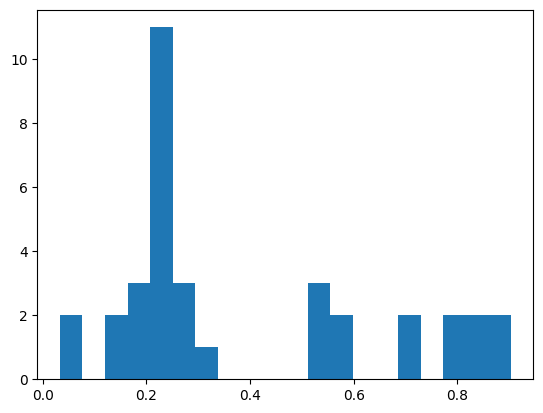

In [117]:
plt.hist(mat_tani_second_highest_val, 20)

In [118]:
mat_tani_second_highest_val.mode()

0    0.210084
1    0.281818
2    0.542636
3    0.578947
4    0.726316
5    0.780220
6    0.845238
7    0.903509
dtype: float64

In [119]:
mat_tani_second_highest_val.mean()

0.395348273798481

## Read data frame 

In [120]:
drug_smiles = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/embeddings/csv/emb_fp_all.csv", 
                         index_col=0)

In [121]:
drug_names = list(drug_smiles.index)
drug_smiles_csr = csr_matrix(drug_smiles.values)
# cl_hier = cf.hierarchical_clustering(drug_smiles_csr, dists=[0.2,0.4,0.6,0.8])
cl_hier = cf.hierarchical_clustering(drug_smiles_csr, dists=[0.50,0.60,0.70])

clusters_2_drug = {}

Row 0.
Reassigning compounds to the closest clusters.
Row 0.
Reassignement changed 0 assignments.
Total 84 clusters.
Row 0.
Reassigning compounds to the closest clusters.
Row 0.
Reassignement changed 0 assignments.
Total 81 clusters.
Row 0.
Reassigning compounds to the closest clusters.
Row 0.
Reassignement changed 0 assignments.
Total 76 clusters.


/tmp/ipykernel_2625030/285779884.py:4: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  cl_hier = cf.hierarchical_clustering(drug_smiles_csr, dists=[0.50,0.60,0.70])


## Read annotated data frame 

In [122]:
annotation = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv")

In [123]:
valid_cpd = np.unique(annotation.CPD_NAME)

## Perform separation

In [124]:
for i, clus in enumerate(cl_hier):
    if clus not in clusters_2_drug:
        clusters_2_drug[clus] = []
    clusters_2_drug[clus].append(drug_names[i])

In [125]:
c = 0
for i in clusters_2_drug:
    if len(clusters_2_drug[i]) > 1:
        print(clusters_2_drug[i])
        c+=1
c

['AG-1478', 'AZ701']
['ALLN', 'calpain inhibitor 2 (ALLM)', 'calpeptin', 'caspase inhibitor 1 (ZVAD)', 'cathepsin inhibitor I', 'leupeptin', 'MG-132', 'proteasome inhibitor I']
['arabinofuranosylcytosine', 'puromycin']
['bohemine', 'olomoucine', 'roscovitine']
['colchicine', 'demecolcine']
['cytochalasin B', 'cytochalasin D']
['deoxymannojirimycin', 'deoxynojirimycin']
['docetaxel', 'taxol']
['etoposide', 'podophyllotoxin']
['genistein', 'quercetin']
['mevinolin/lovastatin', 'simvastatin']
['PD-169316', 'SB-202190', 'SB-203580']
['sodium butyrate', 'valproic acid']
['vinblastine', 'vincristine']
['AZ258', 'AZ841']


15

In [126]:
# leavouts = []
# np.random.seed(42)
# for i in clusters_2_drug:
#     if len(clusters_2_drug[i]) > 1:
#         leavouts.append(np.random.choice(clusters_2_drug[i]))

# leavouts

## Try Splito

### Scaffold

In [147]:
import splito

In [148]:
unique_smiles = np.unique(bbbc021_index.SMILES)
smiles2drug = dict(zip(bbbc021_index.SMILES, bbbc021_index.CPD_NAME))

In [164]:
# Define scaffold split
splitter = splito.ScaffoldSplit(smiles=unique_smiles.tolist(), n_jobs=-1, test_size=0.27, random_state=55)

In [165]:
train_idx, test_idx = next(splitter.split(X=unique_smiles))

In [166]:
for sm in unique_smiles[test_idx]:
    print(smiles2drug[sm])

taxol
ALLN
bryostatin
camptothecin
demecolcine
nocodazole
colchicine
DMSO
cytochalasin B
latrunculin B
cisplatin


### Perimeter

In [95]:
# Define scaffold split
splitter = splito.PerimeterSplit(n_jobs=-1, test_size=0.15)

In [96]:
train_idx, test_idx = next(splitter.split(X=unique_smiles))

2024-08-22 22:53:17.908 | DEBUG    | splito.utils:get_kmeans_clusters:68 - To use KMeans with the jaccard metric, we use the Empirical Kernel Map


In [97]:
for sm in unique_smiles[test_idx]:
    print(smiles2drug[sm])

okadaic acid
quercetin
genistein
chlorambucil
epothilone B
cyclophosphamide
MG-132
calpeptin
leupeptin
ALLN
calpain inhibitor 2 (ALLM)
LY-294002
vinblastine
vincristine
PP-2


In [168]:
dict(zip(bbbc021_index.CPD_NAME, bbbc021_index.ANNOT))

{'cytochalasin B': 'Actin disruptors',
 'cytochalasin D': 'Actin disruptors',
 'latrunculin B': 'Actin disruptors',
 'AZ258': 'Aurora kinase inhibitors',
 'AZ841': 'Aurora kinase inhibitors',
 'mevinolin/lovastatin': 'Cholesterol-lowering',
 'simvastatin': 'Cholesterol-lowering',
 'chlorambucil': 'DNA damage',
 'cisplatin': 'DNA damage',
 'etoposide': 'DNA damage',
 'mitomycin C': 'DNA damage',
 'camptothecin': 'DNA replication',
 'floxuridine': 'DNA replication',
 'methotrexate': 'DNA replication',
 'mitoxantrone': 'DNA replication',
 'AZ138': 'Eg5 inhibitors',
 'PP-2': 'Epithelial',
 'alsterpaullone': 'Kinase inhibitors',
 'bryostatin': 'Kinase inhibitors',
 'PD-169316': 'Kinase inhibitors',
 'colchicine': 'Microtubule destabilizers',
 'demecolcine': 'Microtubule destabilizers',
 'nocodazole': 'Microtubule destabilizers',
 'vincristine': 'Microtubule destabilizers',
 'docetaxel': 'Microtubule stabilizers',
 'epothilone B': 'Microtubule stabilizers',
 'taxol': 'Microtubule stabilizers